In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from utils.evaluation_utils import load_data, save_data
import gc
import os

In [2]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if (col_type != object) or (col_type != Timestamp):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

In [5]:
# load data
data_filename = ["../data/raw_data/conformity_result1_2019_yura_1.csv", 
                 "../data/raw_data/conformity_result1_2020_yura_1.csv",
                 "../data/raw_data/conformity_result1_2020_yura_2.csv",
                 "../data/raw_data/conformity_result1_2023_yura_1.csv",
                 "../data/raw_data/conformity_result1_2023_yura_2.csv"]

data = []
for path in data_filename:
    per_data = pd.read_csv(path)
    
    if "2019" in path:
        year_code = [1,0,0]
    elif "2020" in path[0]:
        year_code = [0,1,0]
    elif "2023" in path[0]:
        year_code = [0,0,1]
    per_data[['year_0','year_1','year_2']] = np.tile(year_code, (len(per_data), 1))
    data.append(per_data)
    del per_data
    gc.collect()

data = pd.concat(data, axis=0, ignore_index=True)

# reduce mem
data = reduce_mem(data)
gc.collect()
data.rename(columns={"grid_id":"pid", "weight":"dist", "sc_250_avg":"sci"}, inplace=True)

8545.41 Mb, 2594.14 Mb (69.64 %)


In [6]:
# data sampling
sample_id = data['pid'].drop_duplicates().sample(n=10000)
data = data[data['pid'].isin(sample_id)]

In [7]:
# fill missing values
# 步骤 1: 分组并计算每个组中 'sci' 和 'dist' 的非缺失值数量
non_missing_counts = data.groupby('pid')[['sci','dist']].count()
# 步骤 2: 找出 'sci' 和 'dist' 都是完全缺失的组
groups_to_remove = non_missing_counts[(non_missing_counts['sci'] == 0) | (non_missing_counts['dist'] == 0)].index.get_level_values('pid').unique()
# 步骤 3: 生成要删除的行的索引
indexes_to_drop = data[data.set_index('pid').index.isin(groups_to_remove)].index
data = data.drop(indexes_to_drop)  # 使用 drop 删除这些行
# 步骤 4: 使用均值填充缺失值
data['sci'] = data.groupby('pid')['sci'].transform(lambda x: x.fillna(x.mean()))
data['dist'] = data.groupby('pid')['dist'].transform(lambda x: x.fillna(x.mean()))
# step 5: 重新排序
data = data.sort_values(by=['pid', 'date']).reset_index(drop=True)

In [9]:
# features join
# 1.read individual attributes
attr = pd.read_csv("../data/raw_data/sample_grid_attr_yura_1.csv")
attr.rename(columns = {"grid_count":"pid", "grid_g":"gender", "grid_type":"age"}, inplace=True)
be_varis = pd.read_csv("../data/raw_data/BE_varis.csv")
#attr = pd.merge(attr, be_varis[['fnid','density','landusemix','road_density','center','subway','edu','married','rent']], on='fnid',how="left")
attr = pd.merge(attr, be_varis[['fnid','edu','married','rent']], on='fnid',how="left")
# 对没有fnid记录的样本，取全样本均值填充缺失值
attr.fillna(attr.mean(), inplace=True)

data = pd.merge(data, attr.drop(columns=['date']), on='pid',how="left")

In [10]:
# 2. individual travel attributes
spatial_ent = pd.read_csv("../data/raw_data/sample_poi_month_entro_yura.csv")
spatial_ent.rename(columns={"grid_id":"pid", "entropy":"spatial_ent"}, inplace=True)
temperal_ent = pd.read_csv("../data/raw_data/sample_move_month_entro_yura.csv")
temperal_ent.rename(columns={"grid_id":"pid", "entropy":"temperal_ent"}, inplace=True)
# merge them
data['year_month'] = (data['date']/100).astype('int')
data = pd.merge(data, spatial_ent, on=['pid','year_month'], how="left")
data = pd.merge(data, temperal_ent, on=['pid','year_month'], how="left")
# fill 0
data['spatial_ent'] = data['spatial_ent'].fillna(0)
data['temperal_ent'] = data['temperal_ent'].fillna(0)

In [11]:
# 3.case data
case = pd.read_csv("../data/raw_data/case_series.csv")
data = pd.merge(data, case[['date','voluntary']], on="date", how="left")
data["voluntary"] = data["voluntary"].fillna(0)

In [12]:
# 4.weather data
weather = pd.read_csv("../data/raw_data/weather_info.csv")
data = pd.merge(data, weather, on="date", how="left")

In [13]:
# features construction
data['weekday'] = pd.to_datetime(data['date'].astype(str), format="%Y%m%d").dt.weekday
holidays_conditions = (
(data['date'].isin([20190101, 20200101])) |
(data['date'].between(20190204, 20190210) | data['date'].between(20200124, 20200202)) |
(data['date'].between(20190405, 20190407) | data['date'].between(20200404, 20200406) | (data['date'] == 20230405)) |
(data['date'].between(20190501, 20190504) | data['date'].between(20200501, 20200505) | data['date'].between(20230429, 20230503)) |
(data['date'].between(20230622, 20230624)))

data['festivals'] = np.where(holidays_conditions, 1, 0)

In [14]:
# policy variables (E1 & E2)
date_conditions = [
    (data['date'].between(20200124, 20200223)),
    (data['date'].between(20200224, 20200508)),
    #(data['date'].between(20200509, 20201231))
]
event_columns = ['E1','E2']
for col, cond in zip(event_columns, date_conditions):
    data[col] = np.where(cond, 1, 0)

In [15]:
# individual attributes binning
income_thre = data['rent'].quantile(q=[0, 0.2, 0.4, 0.6, 0.8, 1])
data['age'] = pd.cut(data['age'], bins=[0, 5, 13, 16, float('inf')], labels=['Young', 'Adult', 'MiddleElder', 'Elder'], right=False)
data['gender'] = data['gender'].map({1: 'Male', 2: 'Female'})
data['income'] = pd.cut(data['rent'], bins=[0] + list(income_thre)[1:], labels=['Bottom', 'Lower', 'Middle', 'Upper', 'Superior'], right=True, include_lowest=True)

# Converting columns to category type with specific levels
data['age'] = data['age'].astype('category')
data['gender'] = data['gender'].astype('category')
data['income'] = pd.Categorical(data['income'], categories=["Bottom", "Lower", "Middle", "Upper", "Superior"], ordered=True)

le = LabelEncoder()
ind_attr_cols = ['gender', 'age', 'income']
for col in ind_attr_cols:
    data[col] = le.fit_transform(data[col])

In [16]:
# weekday one-hot encoding
weekday_encoded = pd.get_dummies(data['weekday'], prefix='weekday').astype(int)
data = data.drop('weekday', axis=1)
data= pd.concat([data, weekday_encoded], axis=1)

In [17]:
 # treatment and outcome - log transformation
data['sci'] = np.log(data['sci'] + 1)
data['dist'] = np.log(data['dist'] + 1)
data['voluntary'] = np.log(data['voluntary'] + 1)

# shift获得t-1列（voluntary是否需要t-1）
# use yesterday norm_mean as conformity factor
data[['sci_yes','dist_yes','voluntary_yes']] = data.groupby('pid')[['sci','dist','voluntary']].shift(1)
# delete null in conformity and dist_yes (i.e. delete the first day in every year)
data = data.dropna(subset=['sci_yes','dist_yes','voluntary_yes']).reset_index(drop=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880000 entries, 0 to 4879999
Data columns (total 33 columns):
 #   Column         Dtype  
---  ------         -----  
 0   pid            int32  
 1   date           int32  
 2   dist           float16
 3   sci            float32
 4   year_0         int8   
 5   year_1         int8   
 6   year_2         int8   
 7   gender         int64  
 8   age            int64  
 9   fnid           float64
 10  edu            float64
 11  married        float64
 12  rent           float64
 13  year_month     int64  
 14  spatial_ent    float64
 15  temperal_ent   float64
 16  voluntary      float64
 17  temperature    float64
 18  percipit       float64
 19  festivals      int64  
 20  E1             int64  
 21  E2             int64  
 22  income         int64  
 23  weekday_0      int64  
 24  weekday_1      int64  
 25  weekday_2      int64  
 26  weekday_3      int64  
 27  weekday_4      int64  
 28  weekday_5      int64  
 29  weekday_6     

In [19]:
data.head()

,pid,date,dist,sci,year_0,year_1,year_2,gender,age,fnid,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,sci_yes,dist_yes,voluntary_yes
0,12023,20190102,2.017578,4.242451,1,0,0,0,0,25498.0,...,0,0,1,0,0,0,0,7.425946,2.244141,0.0
1,12023,20190103,0.000000,7.956927,1,0,0,0,0,25498.0,...,0,0,0,1,0,0,0,4.242451,2.017578,0.0
2,12023,20190104,0.000000,7.206891,1,0,0,0,0,25498.0,...,0,0,0,0,1,0,0,7.956927,0.000000,0.0
3,12023,20190105,2.671875,5.529972,1,0,0,0,0,25498.0,...,0,0,0,0,0,1,0,7.206891,0.000000,0.0
4,12023,20190106,0.000000,5.490638,1,0,0,0,0,25498.0,...,0,0,0,0,0,0,1,5.529972,2.671875,0.0


In [20]:
data.to_csv("../data/sample_1w_dataframe.csv", index=False)

In [2]:
data = pd.read_csv("../data/raw_data/sample_mobile_flow_rango.csv")
data.head()

,grid_id,yearmonth,month_duration,month_ltime
0,69566445,20230801,98993,8240.0
1,69564867,20230801,57113,129749981.0
2,69563436,20230501,31624,267612265.0
3,69561851,20190401,37140,NaN
4,69561658,20230801,8408,345302597.0


In [3]:
data['month_ltime'] = data['month_ltime'].fillna(0)
data['flow'] = data['month_ltime'] / data['month_duration']

## 数据集处理
1. 删掉多余的建成环境指标
2. 生成三年的数据，其中treatment只有sci，policy作为协变量
3. 提取出20年单独的数据

In [2]:
dataset = load_data("../data/sample_32w_add.h5")

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 25)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [3]:
index_to_remove = dataset['covariates'].shape[2] - 5  # 假设shape[2]是23，倒数第五列的索引为18
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 24)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [4]:
dataset['covariates'][0,0,:]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.8604612e-03,
       4.7539836e-01, 0.0000000e+00, 7.7867340e+01, 5.2744341e+00,
       1.3200000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [2]:
dataset = load_data("../data/sample_32w_add_final.h5")

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 23)
float32
outcomes
(981651, 161, 1)
float32
previous_covariates
(981651, 160, 23)
float32
previous_treatments
(981651, 160, 3)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 3)
float32


covariate_cols = ['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density', 'entropy','flow','temperature','percipit']
    ; treatment_cols = ['sci_yes','E1','E2']

In [3]:
# # 列表中 'landusemix', 'road_density', 'center', 'subway' 的索引
# columns_to_remove = [16, 17, 18, 19]  # 以0为起始索引

# # 删除 covariates 中的指定列
# dataset['covariates'] = np.delete(dataset['covariates'], columns_to_remove, axis=2)

# # 删除 previous_covariates 中的指定列
# dataset['previous_covariates'] = np.delete(dataset['previous_covariates'], columns_to_remove, axis=2)

# for key in dataset.keys():
#     print(key)
#     print(dataset[key].shape)
#     print(dataset[key].dtype)

此时的covariate列
['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density', 'entropy','flow','temperature','percipit']

In [5]:
# # 提取出2020年单独的数据，生成2020data
# def obtain_dataset(dataset, column_index, selection=1):
#     dataset_part = {}
#     selected_indices = np.where(dataset['covariates'][:, :, column_index] == selection)[0]
#     unique_selected_indices = np.unique(selected_indices)
#     for key in dataset.keys():
#         dataset_part[key] = dataset[key][unique_selected_indices]
#     return dataset_part

# column_2020 = 13  # index of year 2020 indicator
# dataset20 = obtain_dataset(dataset, column_2020)

In [4]:
# 将政策变量加入covariate和previous_covariates
policy_columns = dataset['treatments'][:, :, -2:]

# 将这两列合并到 covariates 的最后
dataset['covariates'] = np.concatenate((dataset['covariates'], policy_columns), axis=2)

# 从 treatments 删除最后两列
dataset['treatments'] = dataset['treatments'][:, :, :-2]

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 25)
float32
outcomes
(981651, 161, 1)
float32
previous_covariates
(981651, 160, 23)
float32
previous_treatments
(981651, 160, 3)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


此时的covariate列 ['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density', 'entropy','flow','temperature','percipit','policy_1', 'policy_2']

In [5]:
# 删除 previous_treatments 键和其数据
if 'previous_treatments' in dataset:
    del dataset['previous_treatments']

# 删除 previous_covariates 键和其数据
if 'previous_covariates' in dataset:
    del dataset['previous_covariates']

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 25)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [6]:
# 保存生成的dataset20数据
# save_data('../data/sample_32w_2020.h5', dataset20)

# 保存新的dataset
save_data('../data/sample_32w_add.h5', dataset)

Finish ../data/sample_32w_add.h5!


In [3]:
ps = np.load("results/rmsn_all_data_no_deconfound_use_confounders_False/propensity_scores.npy")
print(ps)

[[[ 1.        ]
  [ 0.2186165 ]
  [ 0.24198702]
  ...
  [ 0.60612154]
  [ 0.61547446]
  [ 0.64035958]]

 [[ 1.        ]
  [ 0.39805797]
  [ 0.71758068]
  ...
  [ 0.38854495]
  [ 0.61221683]
  [ 4.38675785]]

 [[ 1.        ]
  [ 2.76691246]
  [ 0.78857583]
  ...
  [ 0.36140603]
  [ 0.2374164 ]
  [ 0.29409248]]

 ...

 [[ 1.        ]
  [ 0.48634303]
  [ 4.63589239]
  ...
  [42.00141525]
  [ 2.19222713]
  [20.19682884]]

 [[ 1.        ]
  [ 1.60044539]
  [ 2.99170256]
  ...
  [ 2.70778584]
  [ 0.38779899]
  [ 9.78914738]]

 [[ 1.        ]
  [ 0.17965211]
  [ 0.1899278 ]
  ...
  [ 0.23001415]
  [ 0.25791985]
  [ 0.26360363]]]


In [3]:
dataset20 = load_data("../data/sample_32w_2020.h5")
for key in dataset20.keys():
    print(key)
    print(dataset20[key].shape)
    print(dataset20[key].dtype)

covariates
(327217, 161, 21)
float32
outcomes
(327217, 161, 1)
float32
previous_covariates
(327217, 160, 21)
float32
previous_treatments
(327217, 160, 3)
float32
sequence_length
(327217,)
int64
treatments
(327217, 161, 3)
float32


### 数据集处理part2
1. 删除流量数据；
2. 删除两个政策项

目前变量情况：
config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
           'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density',
                           'entropy','flow','temperature','percipit','E1','E2'],
            'treatment_cols':['conformity'],

In [2]:
dataset = load_data("../data/sample_32w_add.h5")
for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 25)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [4]:
# 删除flow
index_to_remove = dataset['covariates'].shape[2] - 5  # 假设shape[2]是23，倒数第五列的索引为18
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

In [6]:
# 删除2个政策项
index_to_remove = [dataset['covariates'].shape[2] - 1, dataset['covariates'].shape[2]-2]  # 假设shape[2]是23，倒数第五列的索引为18
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

目前变量情况： config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6', 'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density', 'entropy','temperature','percipit'], 'treatment_cols':['conformity'],

In [9]:
dataset['covariates'][0,0,:]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.8604612e-03,
       4.7539836e-01, 0.0000000e+00, 7.7867340e+01, 5.2744341e+00,
       1.3200000e+01, 0.0000000e+00], dtype=float32)

In [10]:
for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 22)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [11]:
save_data("../data/sample_32w_add_ent.h5", dataset)

Finish ../data/sample_32w_add_ent.h5!


## 个人特征处理

In [2]:
phone_flow = pd.read_csv("../data/raw_data/sample_mobile_flow_rango.csv")
phone_flow.rename(columns={"grid_id":"pid", "yearmonth":"year_month"}, inplace=True)
phone_flow['month_ltime'] = phone_flow['month_ltime'].fillna(0)
phone_flow['flow'] = phone_flow['month_ltime'] / phone_flow['month_duration']

In [9]:
phone_flow['year'] = (phone_flow['year_month'] / 10000).astype("int")
# 映射字典
year_to_period = {
    2019: 1,
    2020: 2,
    2023: 3,
}
# 应用映射生成新列
phone_flow['year_period'] = phone_flow['year'].map(year_to_period)
phone_flow.head()

,pid,year_month,month_duration,month_ltime,flow,year,year_period
0,69566445,20230801,98993,8240.0,0.083238,2023,3
1,69564867,20230801,57113,129749981.0,2271.811689,2023,3
2,69563436,20230501,31624,267612265.0,8462.315488,2023,3
3,69561851,20190401,37140,0.0,0.000000,2019,1
4,69561658,20230801,8408,345302597.0,41068.339320,2023,3


In [12]:
phone_flow_year = phone_flow.groupby(['pid', 'year_period'])['flow'].mean().reset_index(drop=False)
phone_flow_year.to_csv("../data/raw_data/sample_mobile_flow_year_rango.csv",index=False)

In [3]:
unique_pids = phone_flow['pid'].unique()
sample_pids = pd.Series(unique_pids).sample(n=1000, random_state=1)
phone_flow_sample = phone_flow[phone_flow['pid'].isin(sample_pids)]

<Axes: xlabel='flow', ylabel='Count'>

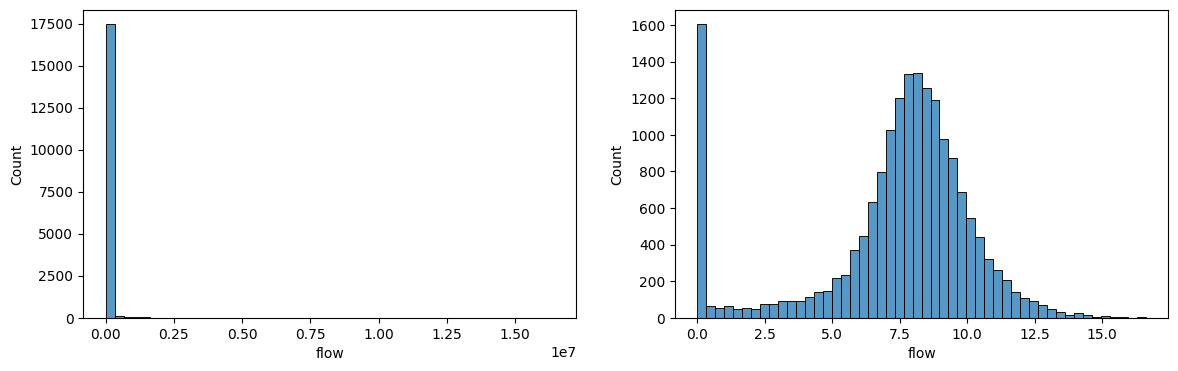

In [16]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.histplot(phone_flow_sample['flow'],bins=50, ax=ax[0])
sns.histplot(np.log(phone_flow_sample['flow']+1),bins=50, ax=ax[1])

In [4]:
spatial_ent = pd.read_csv("../data/raw_data/sample_poi_month_entro_yura.csv")
spatial_ent.rename(columns={"grid_id":"pid", "entropy":"spatial_ent"}, inplace=True)
temperal_ent = pd.read_csv("../data/raw_data/sample_move_month_entro_yura.csv")
temperal_ent.rename(columns={"grid_id":"pid", "entropy":"temperal_ent"}, inplace=True)

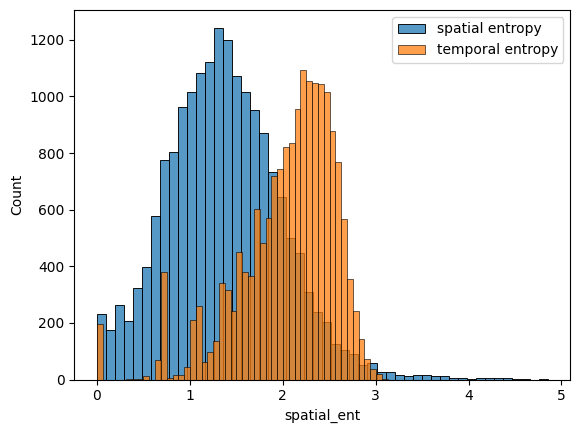

In [5]:
spatial_ent_sample = spatial_ent[spatial_ent['pid'].isin(sample_pids)]
temperal_ent_sample = temperal_ent[temperal_ent['pid'].isin(sample_pids)]
sns.histplot(spatial_ent_sample['spatial_ent'],bins=50, label="spatial entropy")
sns.histplot(temperal_ent_sample['temperal_ent'],bins=50,label="temporal entropy")
plt.legend()

In [8]:
spatio_ent = pd.read_csv("../data/raw_data/sample_entro_fnid_twindow_yura.csv")
# spatio_ent.rename(columns={"grid_id":"pid", "entropy":"spatial_ent"}, inplace=True)

In [9]:
spatio_ent

,grid_id,year_period,entropy
0,479,1,5.142630
1,13034,1,5.088819
2,24387,3,3.788543
3,118334,1,4.570855
4,129073,2,5.035190
...,...,...,...
981646,78923749,3,4.019932
981647,78933199,3,4.977328
981648,78947496,1,4.769897
981649,78948454,3,4.915955


<Axes: xlabel='spatial_ent', ylabel='Count'>

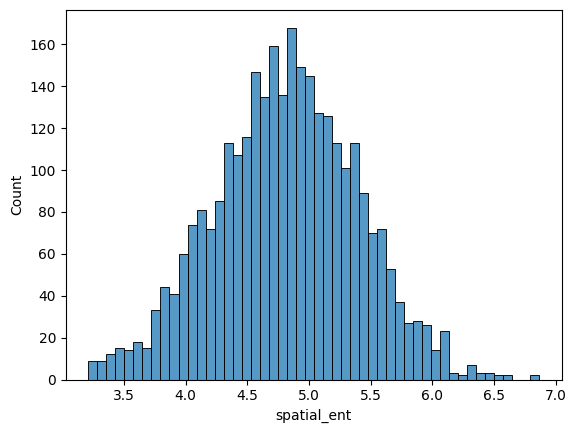

In [7]:
spatio_ent_sample = spatio_ent[spatio_ent['pid'].isin(sample_pids)]
sns.histplot(spatio_ent_sample['spatial_ent'],bins=50)

## 基于流量或时空熵划分人群

In [2]:
dataset = load_data("../data/sample_32w_add.h5")
for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 25)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density',
                  'entropy','flow','temperature','percipit','E1','E2']

In [6]:
def compute_quartiles(dataset, column_index):
    flow_values = dataset['covariates'][:, :, column_index].flatten()
    quartiles = np.percentile(flow_values, [25, 50, 75])
    return quartiles

def obtain_dataset_flow(dataset, column_index):
    quartiles = compute_quartiles(dataset, column_index)
    flow_values = dataset['covariates'][:,:, column_index]
    levels = np.zeros(flow_values.shape, dtype=int)
    levels[flow_values > quartiles[0]] = 1
    levels[flow_values > quartiles[1]] = 2
    levels[flow_values > quartiles[2]] = 3
    dataset_parts = {}
    for level in range(4):
        selected_indices = np.where(levels == level)[0]
        unique_selected_indices = np.unique(selected_indices)
        dataset_part = {}
        for key in dataset.keys():
            dataset_part[key] = dataset[key][unique_selected_indices]
        dataset_parts[level] = dataset_part
    return dataset_parts

In [7]:
# 使用示例
flow_column_index = 20  # 假设flow数据在第三列
dataset_parts = obtain_dataset_flow(dataset, flow_column_index)

### 找出性能最好的超参数

In [5]:
data1 = pd.read_csv("results/rmsn_base_model_params_optimize_use_confounders_False/treatment_rnn_action_inputs_only/treatment_rnn_action_inputs_only.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data1.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: treatment_rnn_action_inputs_only_0.1_6_100_64_0.005_0.5_60_optimal


In [7]:
data2 = pd.read_csv("results/rmsn_base_model_params_optimize_use_confounders_False/treatment_rnn/treatment_rnn.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data2.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: treatment_rnn_0.1_72_100_64_0.01_0.5_60_optimal


In [12]:
data = pd.read_csv("results/rmsn_base_model_params_optimize_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: rnn_propensity_weighted_0.1_72_100_64_0.01_0.5_60_optimal


In [9]:
data3 = pd.read_csv("results/rmsn_add_model_params_optimize_use_confounders_False/treatment_rnn_action_inputs_only/treatment_rnn_action_inputs_only.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data3.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: treatment_rnn_action_inputs_only_0.2_4_100_128_0.005_2.0_60_optimal


In [10]:
data4 = pd.read_csv("results/rmsn_add_model_params_optimize_use_confounders_False/treatment_rnn/treatment_rnn.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data4.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: treatment_rnn_0.1_78_100_64_0.01_0.5_60_optimal


In [13]:
data = pd.read_csv("results/rmsn_add_model_params_optimize_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv",index_col=0)
# 找出具有最小验证损失的列名
min_loss_column = data.loc["validation_loss"].idxmin()

print("最小验证损失的列名是:", min_loss_column)

最小验证损失的列名是: rnn_propensity_weighted_0.1_156_100_64_0.01_2.0_60_optimal


In [7]:
dataset = load_data("../data/sample_32w.h5")
for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 23)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [26]:
np.sum(dataset['covariates'][:,:,1]==0)

153136599

### 不同属性的预测值

In [12]:
years = [19, 20, 23]  # 指定的年份列表
gender_levels = range(2)  # 收入等级从0到4
data = {}  # 用于存储所有数据的字典

# 加载数据到字典
for year in years:
    for level in gender_levels:
        variable_name = f"predict_{year}_gender_{level}"
        file_path = f"../data/result_data/results_{year}_gender_{level}.h5"
        results = load_data(file_path)
        data[variable_name] = np.mean(results['predictions'], axis=0)

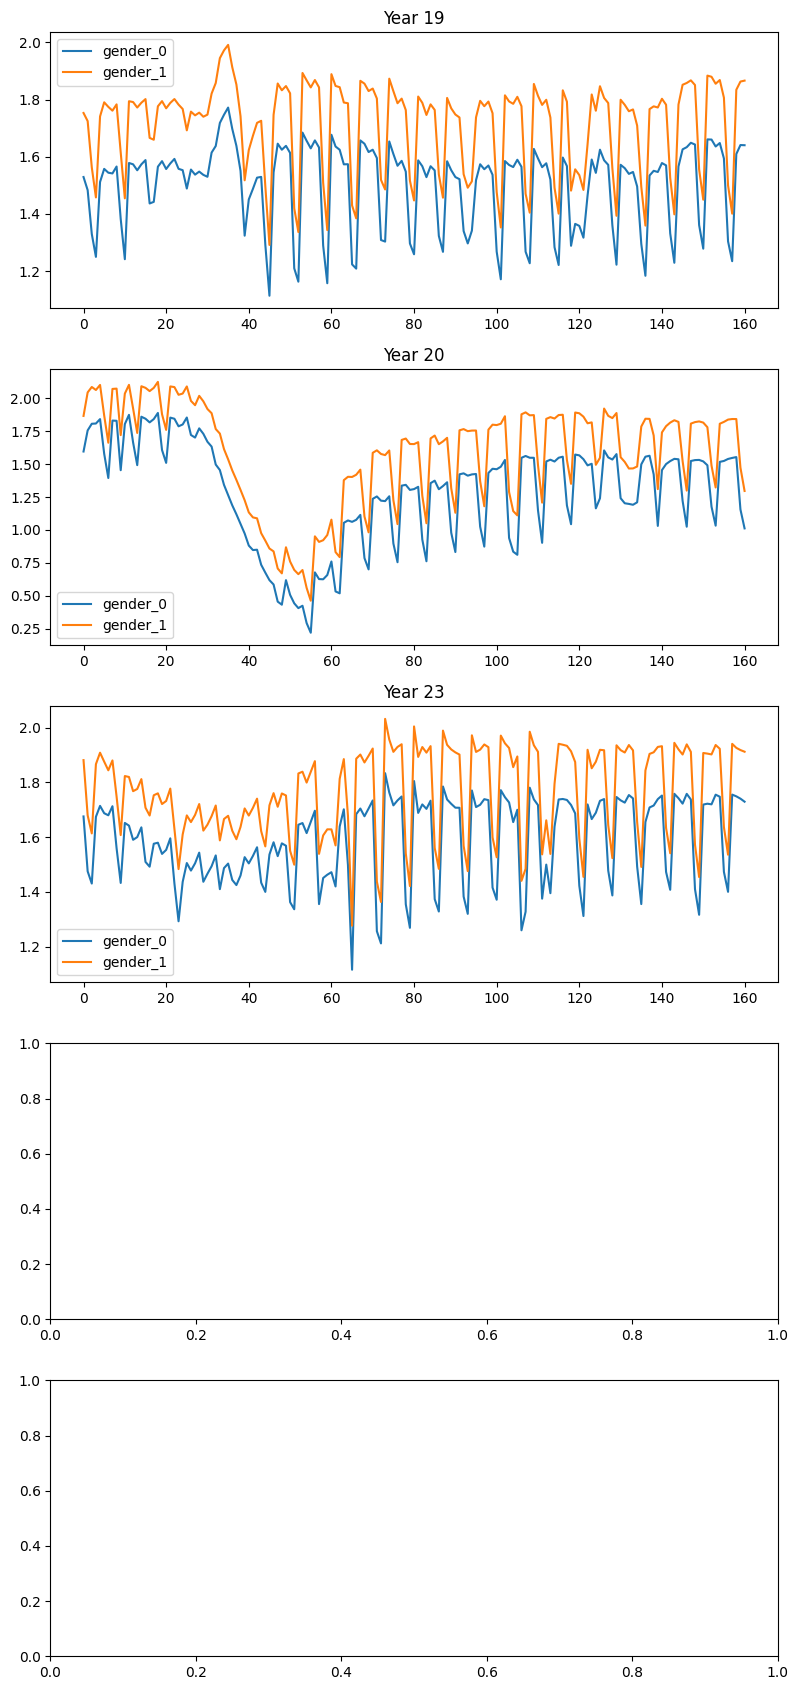

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(8, 17))  # 5行3列

# 绘制每一个热图
for i, year in enumerate(years):
    ax = axs[i]
    for j, level in enumerate(gender_levels):
        variable_name = f"predict_{year}_gender_{level}"
        ax.plot(data[variable_name], label=f'gender_{j}')
        ax.title.set_text(f"Year {year}")
        # ax.set_ylim([-0.7,0.5])
        ax.legend()

plt.tight_layout()
plt.show()

In [27]:
years = [19, 20, 23]  # 指定的年份列表
age_levels = range(3)  # 收入等级从0到4
data = {}  # 用于存储所有数据的字典

# 加载数据到字典
for year in years:
    for level in age_levels:
        variable_name = f"predict_{year}_age_{level}"
        file_path = f"../data/result_data/results_{year}_age_{level}.h5"
        results = load_data(file_path)
        data[variable_name] = np.mean(results['predictions'], axis=0)

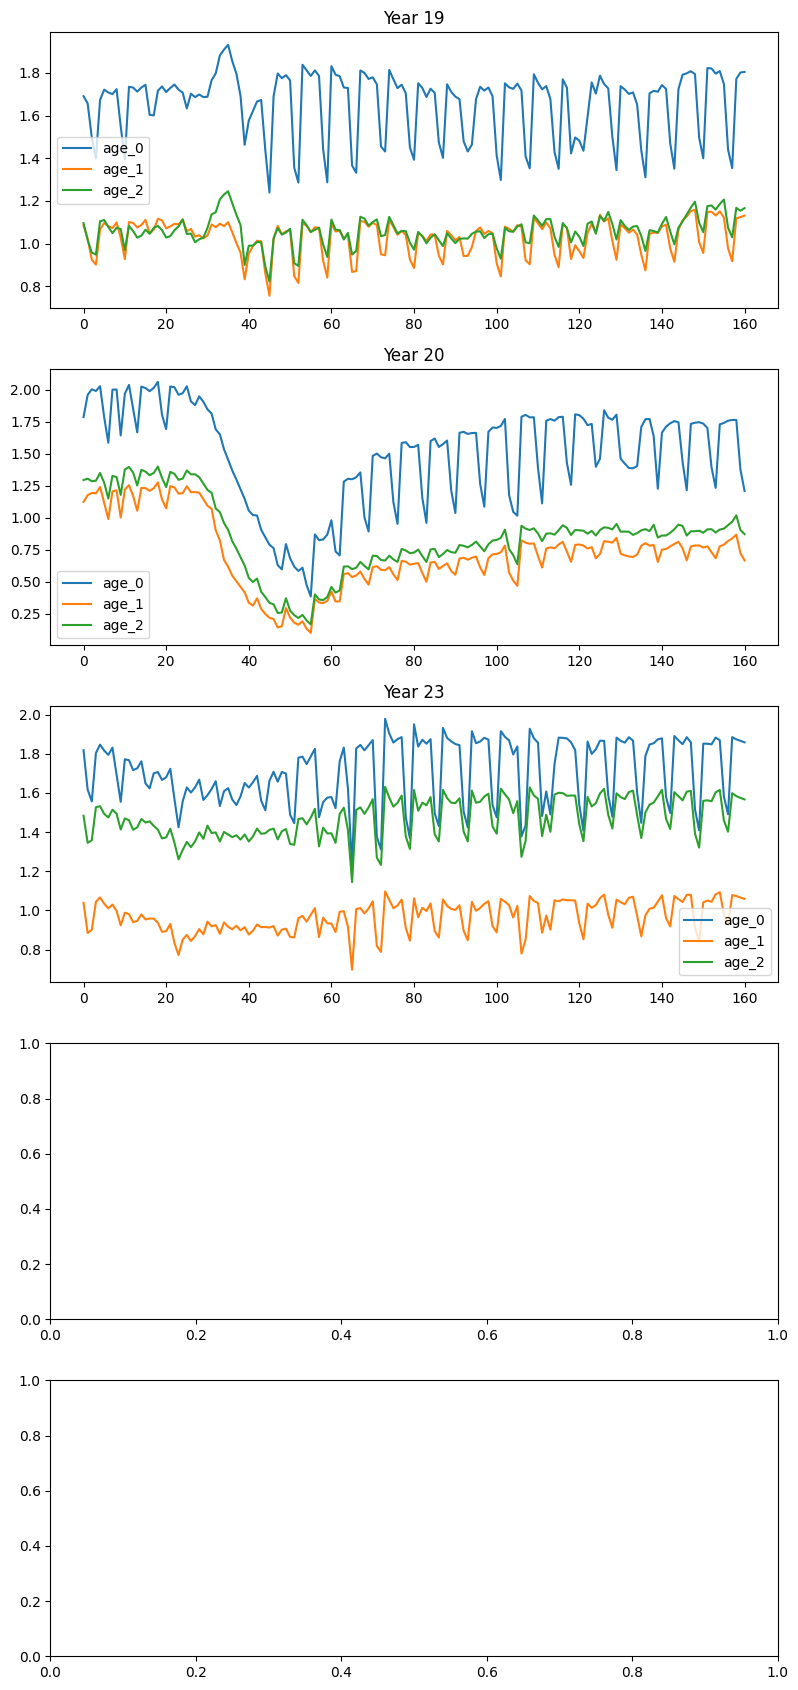

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(8, 17))  # 5行3列

# 绘制每一个热图
for i, year in enumerate(years):
    ax = axs[i]
    for j, level in enumerate(age_levels):
        variable_name = f"predict_{year}_age_{level}"
        ax.plot(data[variable_name], label=f'age_{j}')
        ax.title.set_text(f"Year {year}")
        # ax.set_ylim([-0.7,0.5])
        ax.legend()

plt.tight_layout()
plt.show()

In [2]:
# 设置随机种子以确保结果可复现
np.random.seed(42)

# 定义参数
n_week = 3
n_bin = 4

# 生成随机 ALE 值和样本数量
ale_values = np.random.rand(n_week, n_bin)
sample_counts = np.random.randint(1, 10, size=(n_week, n_bin))

ale_values, sample_counts

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848],
        [0.15601864, 0.15599452, 0.05808361, 0.86617615],
        [0.60111501, 0.70807258, 0.02058449, 0.96990985]]),
 array([[6, 2, 5, 1],
        [6, 9, 1, 3],
        [7, 4, 9, 3]]))

In [3]:
def calculate_weighted_average(values, weights):
    return np.sum(values * weights) / np.sum(weights)

# 计算方法1
def method_1(ale_values, sample_counts):
    n_week, n_bin = ale_values.shape
    weekly_adjusted = np.zeros_like(ale_values)
    
    for i in range(n_week):
        weekly_mean = calculate_weighted_average(ale_values[i], sample_counts[i])
        weekly_adjusted[i] = ale_values[i] - weekly_mean
        
    return np.mean(weekly_adjusted, axis=0)

# 计算方法2
def method_2(ale_values, sample_counts):
    overall_mean = calculate_weighted_average(ale_values, sample_counts)
    adjusted_values = ale_values - overall_mean
    return np.mean(adjusted_values, axis=0)

In [4]:
result_1 = method_1(ale_values, sample_counts)
result_2 = method_2(ale_values, sample_counts)
result_1, result_2

(array([-0.05749541,  0.17020713, -0.16449932,  0.37686149]),
 array([-0.04311572,  0.18458682, -0.15011963,  0.39124118]))

## 处理2020年数据

In [8]:
dataset20 = load_data("../data/all_data_2020_dataset_with_substitute_confounders.h5")
for key in dataset20.keys():
    print(key)
    print(dataset20[key].shape)
    print(dataset20[key].dtype)

covariates
(327217, 161, 21)
float32
outcomes
(327217, 161, 1)
float32
predicted_confounders
(327217, 161, 1)
float32
previous_covariates
(327217, 160, 21)
float32
previous_treatments
(327217, 160, 3)
float32
sequence_length
(327217,)
int64
treatments
(327217, 161, 3)
float32


In [4]:
# 删除predicted_confounders
if 'previous_treatments' in dataset20:
    del dataset20['predicted_confounders']

In [5]:
for key in dataset20.keys():
    print(key)
    print(dataset20[key].shape)
    print(dataset20[key].dtype)

covariates
(327217, 161, 21)
float32
outcomes
(327217, 161, 1)
float32
previous_covariates
(327217, 160, 21)
float32
previous_treatments
(327217, 160, 3)
float32
sequence_length
(327217,)
int64
treatments
(327217, 161, 3)
float32


In [6]:
save_data("../data/sample_32w_2020.h5", dataset20)

Finish ../data/sample_32w_2020.h5!


## 获取32000人的三年数据，做三年汇总和后面的icc

In [2]:
def obtain_dataset(dataset, column_index, selection=1):
        dataset_part = {}
        selected_indices = np.where(dataset['covariates'][:, :, column_index] == selection)[0]
        unique_selected_indices = np.unique(selected_indices)
        for key in dataset.keys():
            dataset_part[key] = dataset[key][unique_selected_indices]
        return dataset_part

In [3]:
dataset = load_data("../data/sample_32w_time.h5")
for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 23)
float32
outcomes
(981651, 161, 1)
float32
previous_covariates
(981651, 160, 23)
float32
previous_treatments
(981651, 160, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [4]:
dataset19 = obtain_dataset(dataset, 12)
dataset20 = obtain_dataset(dataset, 13)
dataset23 = obtain_dataset(dataset, 14)

In [ ]:
# 定义函数根据索引选择数据集中的个体
def select_individuals(data, indices):
    return {key: data[key][indices] for key in data}

# 假设三个数据字典分别是dataset19, dataset20, dataset23
datasets = [dataset19, dataset20, dataset23]

# 分别对三个数据字典进行选择操作
# selected_datasets = [select_individuals(dataset, 32000) for dataset in datasets]
total_samples = dataset19['covariates'].shape[0]
random_indices = np.random.choice(total_samples, size=32000, replace=False)
selected_datasets = [select_individuals(dataset, random_indices) for dataset in datasets]

# 合并三个数据字典
combined_dataset = {
    'covariates': np.concatenate([d['covariates'] for d in selected_datasets], axis=0),
    'outcomes': np.concatenate([d['outcomes'] for d in selected_datasets], axis=0),
    'sequence_length': np.concatenate([d['sequence_length'] for d in selected_datasets], axis=0),  # 假设sequence_length在三年中是一致的
    'treatments': np.concatenate([d['treatments'] for d in selected_datasets], axis=0),
}

# 输出合并后的数据字典的形状
for key, value in combined_dataset.items():
    print(f"{key}: {value.shape}")

covariates: (96000, 161, 23)
outcomes: (96000, 161, 1)
sequence_length: (96000,)
treatments: (96000, 161, 1)


In [ ]:
random_indices

array([109435, 314988,  33972, ..., 161290, 135581, 204438])

In [8]:
save_data("../data/sample_3w2_time_random.h5", combined_dataset)

Finish ../data/sample_3w2_time_random.h5!


In [96]:
data = pd.read_csv("../data/raw_data/conformity_result_2019_rango.csv")

In [97]:
data['radius'] = data['radius']/1000
data.to_csv("../data/raw_data/conformity_result1_2019_rango.csv")

In [98]:
data = pd.read_csv("../data/raw_data/conformity_result_2020_rango.csv")
data['radius'] = data['radius']/1000
data.to_csv("../data/raw_data/conformity_result1_2020_rango.csv")

In [99]:
data = pd.read_csv("../data/raw_data/conformity_result_2023_rango.csv")
data['radius'] = data['radius']/1000
data.to_csv("../data/raw_data/conformity_result1_2023_rango.csv")